In [80]:
#### Run once to install all dependencies.. then comment out..
# uncomment the following line to install/upgrade the PixieDust library
! pip install pixiedust
! pip install watson_developer_cloud --user
! pip install pandas
! pip install matplotlib
! pip install cloudant
! pip install bokeh==0.12.6
! pip install --user --upgrade pixiedust

Requirement already up-to-date: pixiedust in /Users/Srishti.Arora@ibm.com/PixieDust/pixiedust
Requirement already up-to-date: mpld3 in /anaconda3/lib/python3.6/site-packages (from pixiedust)
Requirement already up-to-date: lxml in /Users/Srishti.Arora@ibm.com/.local/lib/python3.6/site-packages (from pixiedust)
Requirement already up-to-date: geojson in /anaconda3/lib/python3.6/site-packages (from pixiedust)


In [82]:
#imports.... Run this each time after restarting the Kernel
import pixiedust
import json
import datetime
from watson_developer_cloud import ConversationV1
import json
import time
import pandas
credentials = json.loads(open('../../credentials.json').read())

In [83]:
#Run this cell each time after restarting the Kernel
from cloudant.client import Cloudant

class cloudant_database(object):
    def __init__(self, db_name):
        self.db_name = db_name
        self.db = None
        self.client = None

    def login(self, username, password, url):
        self.client = Cloudant(username, password, url=url, connect=True)

    def create_database(self):
        self.db = self.client.create_database(self.db_name)

    def list_documents(self, prefix):
        docs = []
        for document in self.db:
            name = document['_id']
            #print(name)
            if name and name.startswith(prefix):
                docs.append(document)
        return docs

    def store_json_log(self, data, doc_id):
        try:
            self.db[doc_id]
        except:
            self.db.create_document({"_id":doc_id, "data": data})
            print('document created')
        else:
            print('document exists')

In [84]:
cdb = cloudant_database('conversation-analysis')
cdb.login(credentials['cloudant']['username'], credentials['cloudant']['password'], credentials['cloudant']['url'])
cdb.create_database()

In [85]:
def create_baseline(prefix):
    utterances = cdb.list_documents(prefix)
    baseline = utterances[len(utterances) - 1]
    baseline = baseline['data']
    return baseline

def create_experiment(prefix):
    ex = cdb.list_documents(prefix)
    experiment_results = ex[len(ex) - 1]
    experiment_results = experiment_results['data']
    return experiment_results

def mark_irrelevant(baseline):
    for row in baseline:
        if len(row['intents']) == 0:
            row['intents'].append({'intent' : 'irrelevant', 'confidence' : 100})
    return baseline


In [86]:
baseline = create_baseline("utterances_")
baseline = mark_irrelevant(baseline_1)
# print(baseline)
experiment_results = create_experiment("experiment_")


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: generator 'CouchDatabase.__iter__' raised StopIteration


IndexError: list index out of range

In [48]:
conversation_local = ConversationV1(
    username=credentials['conversation']['username'],
    password=credentials['conversation']['password'],
    version='2017-05-26')

conversation_prod_ws = credentials['conversation']['workspace_id_prod']
conversation_test_ws = credentials['conversation']['workspace_id_test']

prod_ws = conversation_local.get_workspace(workspace_id=conversation_prod_ws, export=True)
test_ws = conversation_local.get_workspace(workspace_id=conversation_test_ws, export=True)



In [36]:
#count how many times each intent was used per experiment run
def count_intents(list_name, count, prefix):
    for row in list_name:
        name = row['intents'][0]['intent']
        if name not in count:
            count[name] = {'baseline' : 0, 'experiment' : 0}
        keys = count[name].keys()
        count[name][prefix] = count[name][prefix] + 1
    return count

In [37]:
count_1={}
count_1 = count_intents(baseline, count_1,'baseline')
count_1= count_intents(experiment_results, count_1,'experiment')
# print(count_1)


In [72]:
#Creating a data frame for count of intents in baseline and experiments
def create_intent_dataframe(count):
    arr = []    
    for key in count:
        arr.append({'name' : key, 'baseline' : count[key]['baseline'], 'experiment' : count[key]['experiment']})
    intent_distribution_df = pandas.DataFrame(arr)
    return intent_distribution_df

In [73]:
intent_distribution_df = get_intent_distribution_dataframe(count_1)

In [59]:
def create_intent_analysis_dataframe():
    intent_analysis = []
    prod_examples = 0
    test_examples = 0
    intent_analysis.append({'intent' : 'irrelevant', 'baseline': len(prod_ws['counterexamples']), 'experiment' : len(test_ws['counterexamples'])})
    for intent in prod_ws['intents']:
        prod_examples = prod_examples + len(intent['examples'])
        intent_analysis.append({'intent' : intent['intent'], 'baseline' : len(intent['examples']), 'experiment' : 0})
    
    for intent in test_ws['intents']:
        test_examples = test_examples + len(intent['examples'])
        found = False
        for intnt in intent_analysis:
            if intnt['intent'] == intent['intent']:
                found = True
                intnt['experiment'] = len(intent['examples'])
                break

        if not found: 
            intent_analysis.append({'intent' : intent['intent'], 'baseline' : 0, 'experiment' : len(intent['examples'])})
    intent_analysis_df = pandas.DataFrame(intent_analysis)
#     print(test_examples)
#     print(prod_examples)
#     print(intent_analysis)
    return intent_analysis_df

In [60]:
def count_examples(workspace):
    examples = 0
    for intent in workspace['intents']:
        examples = examples + len(intent['examples'])
    return examples

def count_val_syn(workspace):
    values = 0
    synonyms = 0
    for entity in workspace['entities']:
        values = values + len(entity['values'])
        for value in entity['values']:
            synonyms = synonyms + len(value['synonyms'])
    return (values, synonyms)
    

In [62]:
# print(count_examples(test_ws))
# print(count_examples(prod_ws))
# print(count_val_syn(test_ws)[0])
# print(count_val_syn(test_ws)[1])
# print(count_val_syn(prod_ws)[0])
# print(count_val_syn(prod_ws)[1])

2520
9
115
329
0
0


In [63]:
def create_ws_analysis_dataframe():
    ws_analysis = [] 
    ws_analysis.append({'name' : 'intents', 'baseline' : len(prod_ws['intents']), 'experiment' : len(test_ws['intents'])})
    ws_analysis.append({'name' : 'entities', 'baseline' : len(prod_ws['entities']), 'experiment' : len(test_ws['entities'])})
    ws_analysis.append({'name' : 'dialog_nodes', 'baseline' : len(prod_ws['dialog_nodes']), 'experiment' : len(test_ws['dialog_nodes'])})
    ws_analysis.append({'name' : 'counterexamples', 'baseline' : len(prod_ws['counterexamples']), 'experiment' : len(test_ws['counterexamples'])})
    
    prod_examples = count_examples(prod_ws)
    test_examples = count_examples(test_ws)
    ws_analysis.append({'name' : 'examples', 'baseline' : prod_examples, 'experiment' : test_examples})
    
    prod_values = count_val_syn(prod_ws)[0]
    prod_synonyms = count_val_syn(prod_ws)[1]
    test_values = count_val_syn(test_ws)[0]
    test_synonyms = count_val_syn(test_ws)[1]
    
    ws_analysis.append({'name' : 'values', 'baseline' : prod_values, 'experiment' : test_values})
    ws_analysis.append({'name' : 'synonyms', 'baseline' : prod_synonyms, 'experiment' : test_synonyms})
    
    
    ws_analysis_df = pandas.DataFrame(ws_analysis)
    return ws_analysis_df

In [69]:
intent_analysis_df = create_intent_analysis_dataframe()
ws_analysis_df = create_ws_analysis_dataframe()

In [75]:
#make a data frame with the original utterance, the intent from each run, the confidence, whether or not the 
#intent changed, and the confidence delta

def create_delta(baseline, experiment_results):
    merged1 = [{"text": b["text"], "intent_1" : b['intents'][0]['intent'], 
           "conf_1" : b['intents'][0]['confidence']} for b in baseline]
    merged2 =[{"text": b["text"], "intent_2" : b['intents'][0]['intent'], 
           "conf_2" : b['intents'][0]['confidence']} for b in experiment_results]
    merged = list(zip(merged1, merged2))

    merged = [{'intent_1': b[0]['intent_1'], 'conf_1': b[0]['conf_1'],
          'intent_2': b[1]['intent_2'], 'conf_2': b[1]['conf_2'], 
          'intent_changed' : b[0]['intent_1'] != b[1]['intent_2'],
          'conf_delta' : b[1]['conf_2'] - b[0]['conf_1'], 'text' : b[0]['text']} for b in merged]
    experiment_run_dataframe = pandas.DataFrame(merged)
    experiment_run_dataframe = experiment_run_dataframe.loc[experiment_run_dataframe['intent_changed']==True]
    return experiment_run_dataframe



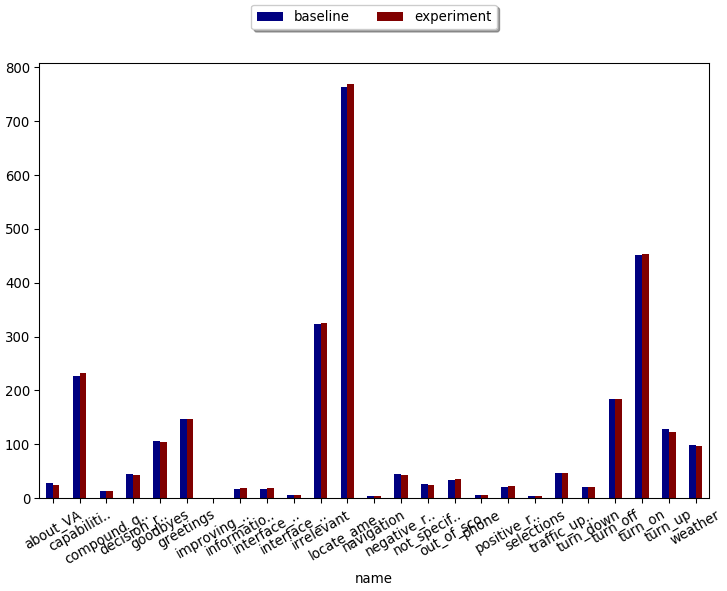

In [79]:
experiment_run_dataframe = create_delta(baseline, experiment_results)

display(ws_analysis_df)
display(intent_analysis_df)
display(intent_distribution_df)
display(experiment_run_dataframe)
    

#pdf = pdf.loc[pdf['conf_delta']>0.1]
#display(pdf)